# Using polynomial features

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
import warnings
import statsmodels.api as sm 
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib.ticker import FuncFormatter, MaxNLocator
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

## 1. List of Functions and Class


### 1.1 Functions for EDA
- plot_heat_map
- plot_scatter_plot

In [2]:
# Function to plot a heat map of a list of independent variables against all other variables
def generate_heat_map(list_ind, df):
    plt.figure(figsize = (20,25))
    plt.rcParams.update({'font.size': 22})
    corr = df.corr()
    sns.heatmap(corr[list_ind], cmap= 'coolwarm', annot = True)

In [3]:
# Function to plot scatter plot of a given list of independent and dependent variables
def plot_scatter_plot(list_ind, list_dep, df):
    
    #plt.figure()
#     plt.rcParams.update({'font.size': 22})
#     plt.figsize=(30,45)

    for i1, j1 in enumerate(list_dep):
        for i2, j2 in enumerate(list_ind):
            title = "Ind: {} | Dep: {}".format(j2, j1)
            plt.figure(figsize=(15,8))
            plt.rcParams.update({'font.size': 15})
            plt.scatter(df[j2], df[j1], color='blue', label='Actual')
            plt.title(title,fontsize=16)
            plt.xlabel(j2, fontsize = 16)
            plt.ylabel(j1, fontsize = 16)
            plt.xticks(fontsize = 12)
            plt.yticks(fontsize = 12)
            plt.show()
#             correlation = df[j2].corr(df[j1])
#             ax = df.plot.scatter(x=j2, y=j1, c='DarkBlue', title="x: {x_name}; y: {y_name}; corr: {corr}".format(x_name = j2, y_name = j1, corr = correlation), figsize=(30,45), fontsize=22)

### 1.2 Functions for Data Cleaning
- display_missing_indexes
- display_missing_val_dates
- group_missing_val_by_month

In [4]:
def display_missing_indexes(df):
    m = []
    assigned_index = []
    calculated_index = []
    
    k = 0
    for i, j in enumerate(df_us.index.tolist()):
        if j > i + len(m):
            
            assigned_index.append(j)
            calculated_index.append(i)
            m.append(1)

    print("\n\nTotal missing index count = ", len(m))
    
    for i in range(len(m)):
        print("Assigned Index: ", assigned_index[i], "   Calculated Index: ", calculated_index[i])

In [5]:
# Function to display all dates with a missing value for a list of specific variables.
def display_missing_val_dates(list_var, df):
    missing = [0] * len(list_var)
    
    print("First index and date in the record: ", df.head(1)['date'],"\n")
    print("Last index and date in the record: ", df.tail(1)['date'],"\n")
    
    for i, j in enumerate(list_var):
        print("Dates of Missing ", j, " data:")
        for index, row in df.iterrows():
            if pd.isnull(row[j]):
                print(row['date'])
                missing[i] += 1
        print("Total Missing Values: ", missing[i], "\n\n")       

In [6]:
# Function to group missing values of a list of specific variables by month.
def group_missing_val_by_month(list_var, dataframe):
    # Create a month column
    date_str = []
    tmp_str = ''
    for index, row in dataframe.iterrows():
        tmp_str = str(row['date'])
        date_str.append(tmp_str[0:7])
    dataframe['month'] = date_str
    
    # Printing Missing Values Groupby Month
    for i, j in enumerate(list_var):
        print('Group Missing values of', j, 'by month')
        missing = dataframe.groupby('month')
        print(missing.apply(lambda x: x[x[j].isna() == True]['month'].count()))
        print("\n")

### 1.3 Functions and a Class for Modelling
- cubic_func
- Model class

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [8]:
def cubic_func(x, a, b, c, d):
    return a * x ** 3 + b * x ** 2 + c * x + d

In [9]:
class Model:
    def __init__(self, x, y, x_name, y_name, model_name):
        self.x = x
        self.y = y
        self.x_train = []
        self.x_train_date = []
        self.y_train = []
        self.x_test = []
        self.y_test = []
        self.y_train_pred = []
        self.y_test_pred = []
        self.x_name = x_name
        self.y_name = y_name
        self.model = object()
        self.model_pipeline = object()
        self.model_name = model_name
    
    
    def get_curve_const(self):
        const = curve_fit(cubic_func, self.x_train, self.y_train)
        return const[0][0], const[0][1], const[0][2], const[0][3]
    
    
    def build_model(self):
        # Train test split
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, train_size=0.7, test_size=0.3, random_state=100)
        
        # Converting x_train date datatype
        if self.x_train.dtype == '<M8[ns]':
            
            self.x_train_date = ['{}-{}-{}'.format(y,m,d) for y, m, d in map(lambda x: str(x).split('-'), self.x_train)]# save this to plot regression graph
            self.x_train = pd.to_datetime(self.x_train)
            self.x_train = self.x_train.map(dt.datetime.toordinal)
            self.x_train = self.x_train.values
            self.x_test = pd.to_datetime(self.x_test)
            self.x_test = self.x_test.map(dt.datetime.toordinal)  
            self.x_test = self.x_test.values
        
        # Reshaping numpy.ndarray
        x_train_res = self.x_train.reshape(-1, 1)
        x_test_res = self.x_test.reshape(-1, 1)
        y_train_res = self.y_train.reshape(-1, 1)
        y_test_res = self.y_test.reshape(-1, 1)

        # Getting the best fit polynomial curve constant
        a, b, c, d = self.get_curve_const()

        # Building the model
#         x_poly_reg_train = cubic_func(x_train_res, a, b, c, d)
#         x_poly_reg_test = cubic_func(x_test_res, a, b, c, d)
#         self.model = LinearRegression()
#         self.model.fit(x_poly_reg_train.reshape(-1, 1), y_train_res)
# #         self.model = sm.OLS(y_train_res, x_poly_reg_train).fit()
#         self.y_train_pred = self.model.predict(x_poly_reg_train.reshape(-1, 1))
#         self.y_test_pred = self.model.predict(x_poly_reg_test.reshape(-1, 1))
        
        
        model = LinearRegression()
        model.fit(x_train_res, y_train_res)
        Input=[('polynomial',PolynomialFeatures(degree=3)),('modal',LinearRegression())]
        self.model=Pipeline(Input)
        self.model.fit(x_train_res, y_train_res)
        self.y_train_pred = self.model.predict(x_train_res)
        self.y_test_pred = self.model.predict(x_test_res)
        print(self.model)
    
    def plot_model(self):
        orders = np.argsort(self.x_train.ravel())
        
        plt.figure(figsize=(15,8))
        plt.rcParams.update({'font.size': 15})
        plt.scatter(self.x_train, self.y_train, color='blue', label='Actual')
        plt.plot(self.x_train[orders], self.y_train_pred[orders], color = 'red', label='Predicted')
        plt.title(self.model_name,fontsize=16)
        plt.xlabel(self.x_name,fontsize=16)
        plt.ylabel(self.y_name,fontsize=16)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.legend()
        plt.show()

        
    def plot_model_with_date(self):
        # To arrange numpy,ndarray in ascending order
        orders = np.argsort(self.x_train.ravel()) 
        fig, ax = plt.subplots()
        ax.scatter(self.x_train, self.y_train, color='blue', label='Actual')
        ax.plot(self.x_train[orders], self.y_train_pred[orders], color = 'red', label='Predicted')
        
        self.x_train = self.x_train[orders]
        x_labels = ['' if i%10 != 0 else dt.date.fromordinal(j).strftime('%Y-%m-%d') 
                    for i, j in enumerate(self.x_train)]
        ax.set_xticks(self.x_train)
        ax.set_xticklabels(x_labels)
        ax.tick_params(labelrotation=45)
        ax.set_title(self.model_name, fontsize = 15)
        ax.set_xlabel(self.x_name, fontsize = 15)
        ax.set_ylabel(self.y_name, fontsize = 15)
        fig.set_figheight(8)
        fig.set_figwidth(15)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        
        plt.show()
        

    def compute_r2_score(self):
        print("----- R2 Score Report -----")
        print("Model: ", self.model_name)
        print("Train Set: ", r2_score(self.y_train, self.y_train_pred))
        print("Test Set: ", r2_score(self.y_test, self.y_test_pred))
        
        
    def display_model_summary(self):
        print("\n----- Model Summary -----")
        print(self.model.summary())
    
    
    def perform_residual_analysis(self):
        res = self.y_train - self.y_train_pred
        
        fig = plt.figure(figsize=(15,8))
        sns.distplot(res, bins = 15)
        plt.title("Error Terms", fontsize = 15)
        plt.xlabel("y_train - y_train_pred", fontsize = 15)
        plt.show()
        
    def test_model(self):
        samples = np.array([[6000000000]])
        result = self.model.predict(samples)
        print(int(result))

## 2. Create dataframes
- df_world: includes data from all countries
- df_us: includes data from the United States

In [10]:
# Load excel file into dataframe(df_world)
df_world = pd.read_csv(r'C:\Users\Lenovo\OneDrive\Y2S3\Introduction to Data Science\Assignment\Dataset\owid-covid-data-updated.csv')

In [11]:
# Create a new dataframe for USA
df_us = df_world[df_world['iso_code'] == 'USA']

## 3. Exploratory Data Analysis (EDA)

In [12]:
# Check datatypes 
df_us.dtypes

iso_code                                  object
continent                                 object
location                                  object
date                                      object
total_cases                              float64
new_cases                                float64
new_cases_smoothed                       float64
total_deaths                             float64
new_deaths                               float64
new_deaths_smoothed                      float64
total_cases_per_million                  float64
new_cases_per_million                    float64
new_cases_smoothed_per_million           float64
total_deaths_per_million                 float64
new_deaths_per_million                   float64
new_deaths_smoothed_per_million          float64
reproduction_rate                        float64
icu_patients                             float64
icu_patients_per_million                 float64
hosp_patients                            float64
hosp_patients_per_mi

In [13]:
# Display the first 20 rows of records
df_us.head(20)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
100792,USA,North America,United States,2020-01-22,1.0,NaN,NaN,NaN,NaN,NaN,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
100793,USA,North America,United States,2020-01-23,1.0,0.0,NaN,NaN,NaN,NaN,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
100794,USA,North America,United States,2020-01-24,2.0,1.0,NaN,NaN,NaN,NaN,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
100795,USA,North America,United States,2020-01-25,2.0,0.0,NaN,NaN,NaN,NaN,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
100796,USA,North America,United States,2020-01-26,5.0,3.0,NaN,NaN,NaN,NaN,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,0.75
100797,USA,North America,United States,2020-01-27,5.0,0.0,NaN,NaN,NaN,NaN,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
100798,USA,North America,United States,2020-01-28,5.0,0.0,0.571,NaN,NaN,0.0,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
100799,USA,North America,United States,2020-01-29,6.0,1.0,0.714,NaN,NaN,0.0,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
100800,USA,North America,United States,2020-01-30,6.0,0.0,0.714,NaN,NaN,0.0,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
100801,USA,North America,United States,2020-01-31,8.0,2.0,0.857,NaN,NaN,0.0,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN


In [14]:
# Display the last 20 rows of records
df_us.tail(20)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
101329,USA,North America,United States,2021-07-12,33888961.0,35013.0,23667.429,607275.0,244.0,258.143,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
101330,USA,North America,United States,2021-07-13,33915385.0,26424.0,23981.714,607630.0,355.0,260.571,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
101331,USA,North America,United States,2021-07-14,33947230.0,31845.0,25255.143,607961.0,331.0,265.857,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
101332,USA,North America,United States,2021-07-15,33975642.0,28412.0,26448.143,608244.0,283.0,269.143,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
101333,USA,North America,United States,2021-07-16,34054952.0,79310.0,30886.571,608635.0,391.0,253.000,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
101334,USA,North America,United States,2021-07-17,34067912.0,12960.0,31446.857,608705.0,70.0,243.143,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
101335,USA,North America,United States,2021-07-18,34079960.0,12048.0,32287.429,608840.0,135.0,258.429,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
101336,USA,North America,United States,2021-07-19,34132071.0,52111.0,34730.000,609051.0,211.0,253.714,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
101337,USA,North America,United States,2021-07-20,34174774.0,42703.0,37055.571,609337.0,286.0,243.857,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
101338,USA,North America,United States,2021-07-21,34226806.0,52032.0,39939.429,609670.0,333.0,244.143,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN


In [15]:
# Check the size of df_us
df_us.shape

(557, 60)

### 3.1 Create a new variable & define independent and dependent variables

In [16]:
# Create a new variable: people_partially_vaccinated = people_vaccinated - people_fully_vaccinated
df_us['people_partially_vaccinated'] = df_us['people_vaccinated'] - df_us['people_fully_vaccinated']

# Create a new variable: percent_pop_vaccinated = people_fully_vaccinated / population * 100
df_us['percent_people_vaccinated'] = df_us['people_fully_vaccinated'] / df_us['population'] * 100

# Reassigning the index of df_us
df_us.index = df_us.index - 91593

# Convert string date into datetime
df_us['date'] = pd.to_datetime(df_us['date'], format = '%Y-%m-%d')
# df_us['date'] = pd.to_datetime(df_us['date'])
# df_us['date'] = df_us['date'].map(dt.datetime.toordinal)

In [17]:
# Define independent and deppendent variables
rq1_ind = ['people_fully_vaccinated', 'people_partially_vaccinated']
rq1_dep = ['new_cases_smoothed', 'new_deaths_smoothed']
rq1_vars = rq1_ind + rq1_dep

rq2_ind = ['date']
rq2_dep = ['percent_people_vaccinated']
rq2_vars = rq2_ind + rq2_dep

In [18]:
df_us.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality,people_partially_vaccinated,percent_people_vaccinated
9199,USA,North America,United States,2020-01-22,1.0,NaN,NaN,NaN,NaN,NaN,...,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN
9200,USA,North America,United States,2020-01-23,1.0,0.0,NaN,NaN,NaN,NaN,...,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN
9201,USA,North America,United States,2020-01-24,2.0,1.0,NaN,NaN,NaN,NaN,...,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN
9202,USA,North America,United States,2020-01-25,2.0,0.0,NaN,NaN,NaN,NaN,...,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN
9203,USA,North America,United States,2020-01-26,5.0,3.0,NaN,NaN,NaN,NaN,...,10.79,19.1,24.6,NaN,2.77,78.86,0.926,0.75,NaN,NaN


In [19]:
df_us.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality,people_partially_vaccinated,percent_people_vaccinated
9199,USA,North America,United States,2020-01-22,1.0,NaN,NaN,NaN,NaN,NaN,...,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN
9200,USA,North America,United States,2020-01-23,1.0,0.0,NaN,NaN,NaN,NaN,...,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN
9201,USA,North America,United States,2020-01-24,2.0,1.0,NaN,NaN,NaN,NaN,...,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN
9202,USA,North America,United States,2020-01-25,2.0,0.0,NaN,NaN,NaN,NaN,...,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN
9203,USA,North America,United States,2020-01-26,5.0,3.0,NaN,NaN,NaN,NaN,...,10.79,19.1,24.6,NaN,2.77,78.86,0.926,0.75,NaN,NaN


### 3.2 Plot EDA graphs

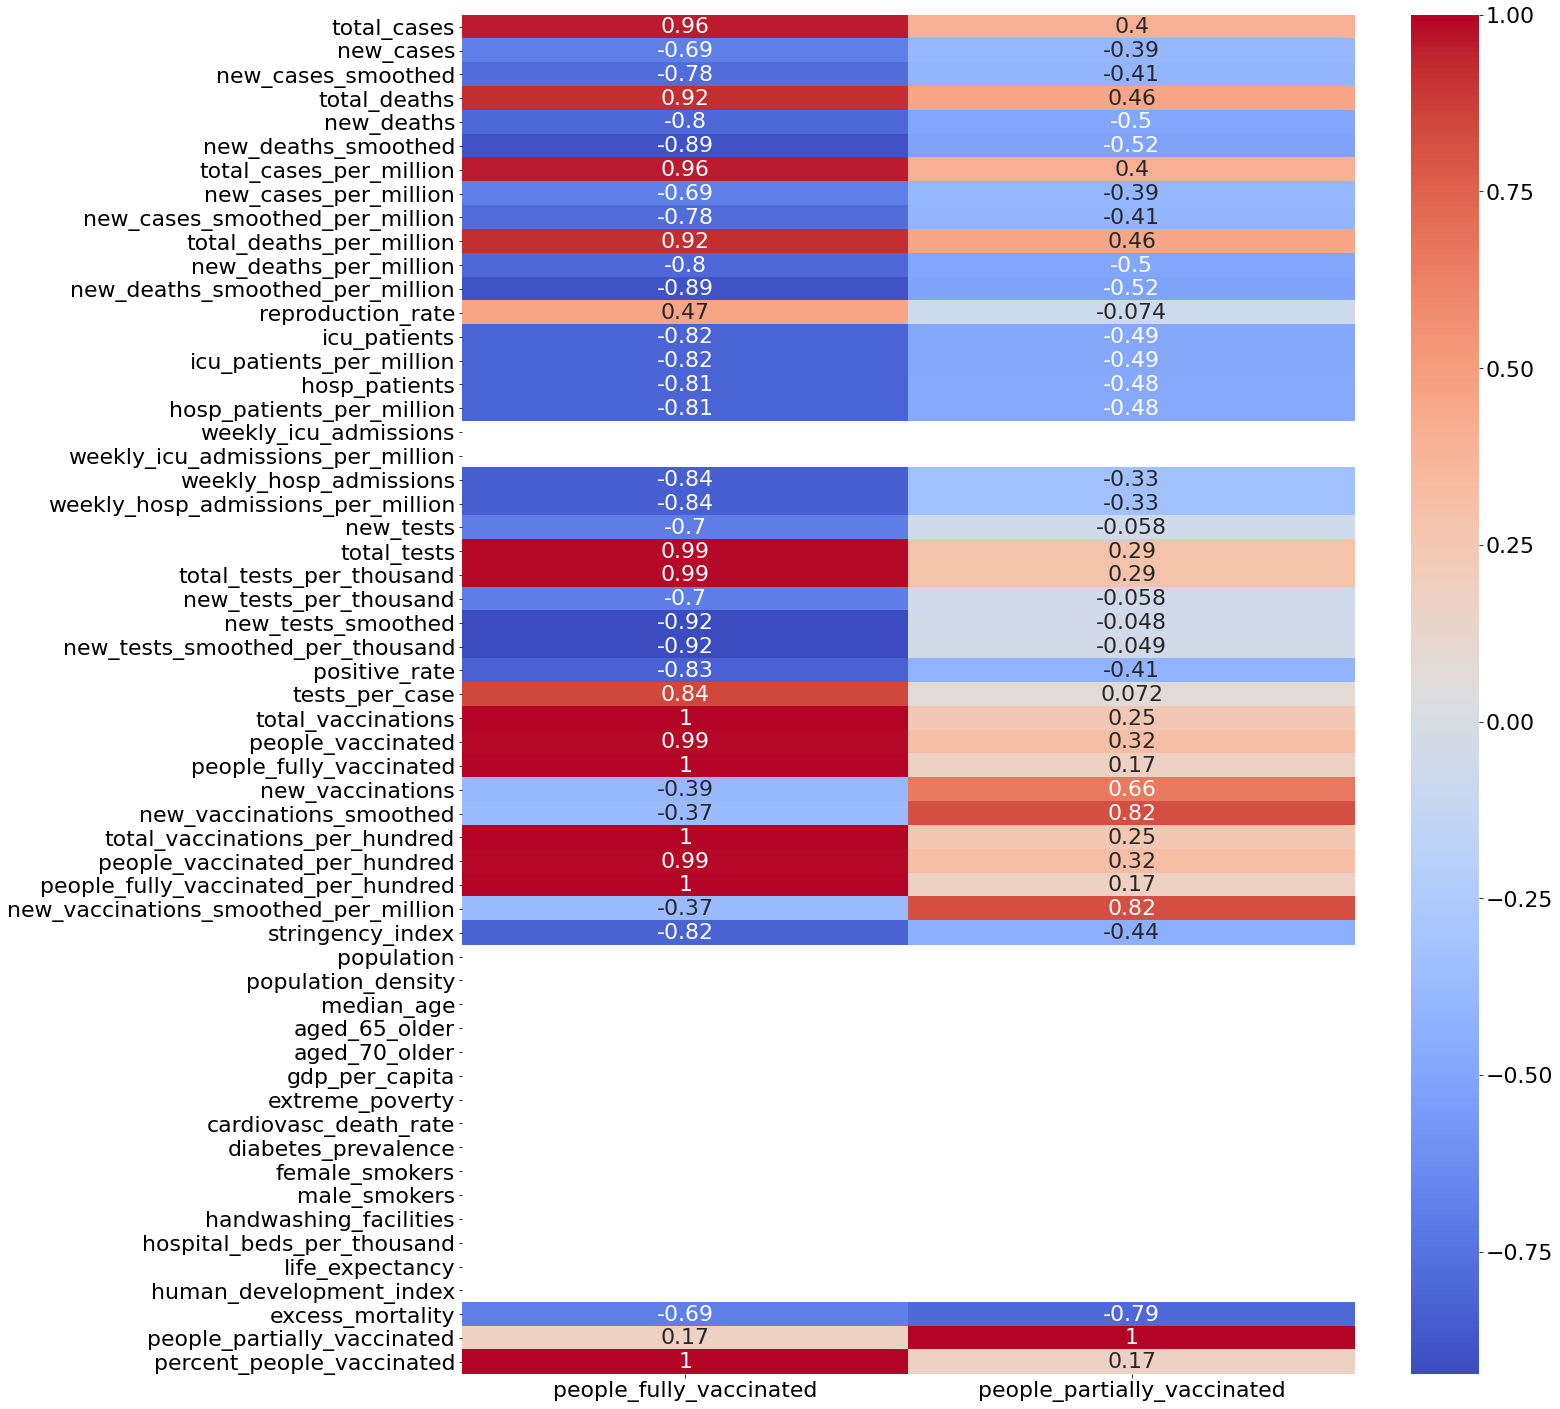

In [20]:
# Generating heatmap for the independent variables of both RQ1 and RQ2
generate_heat_map(rq1_ind, df_us)

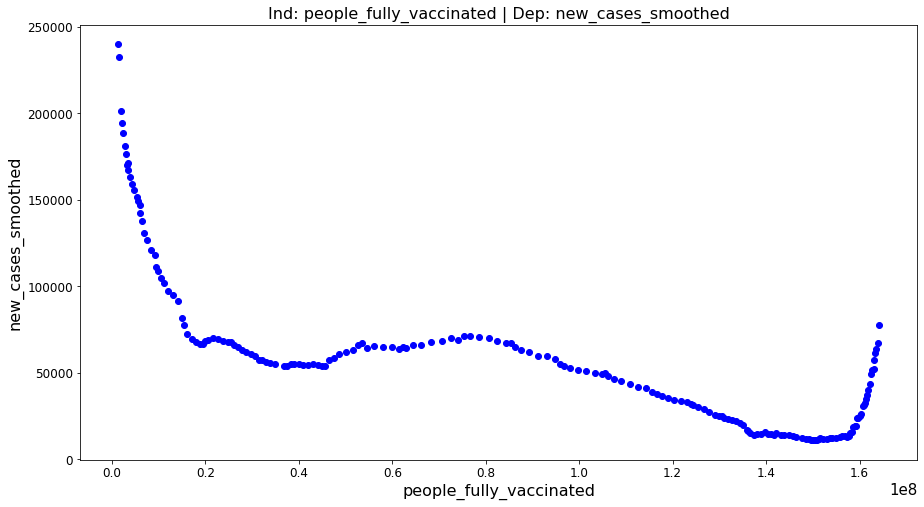

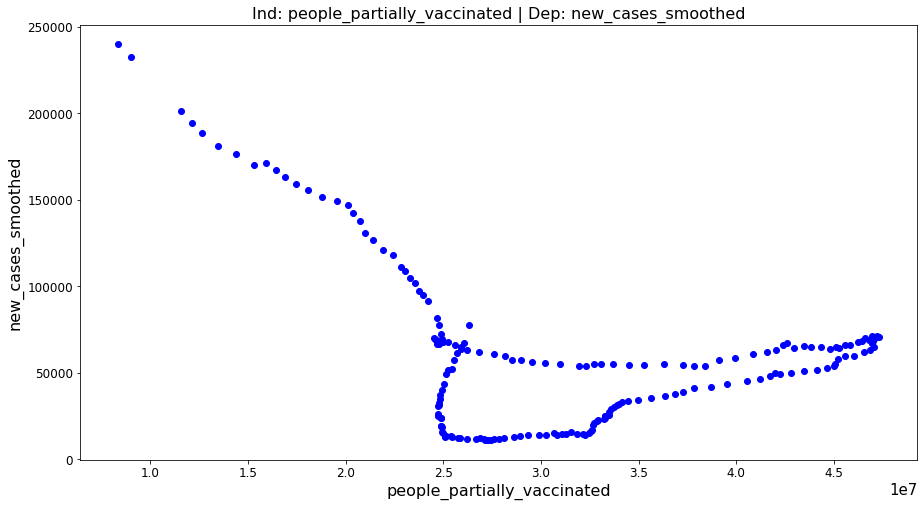

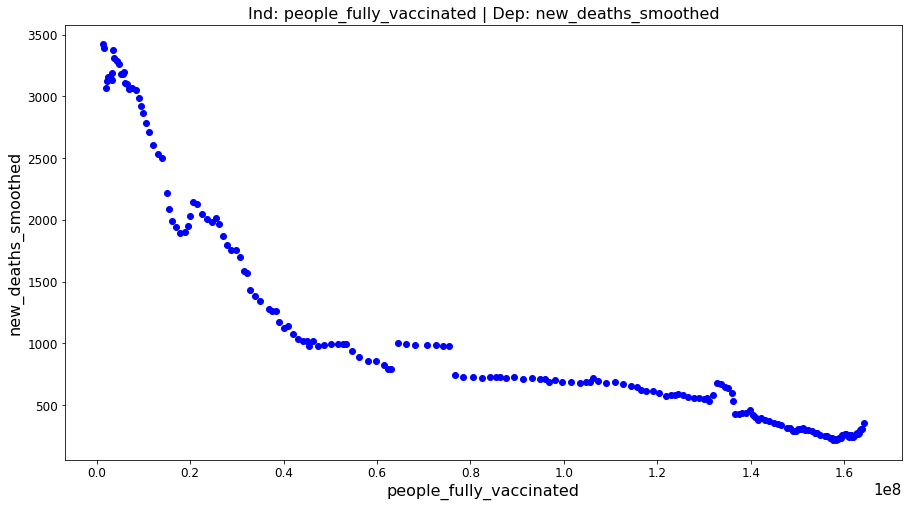

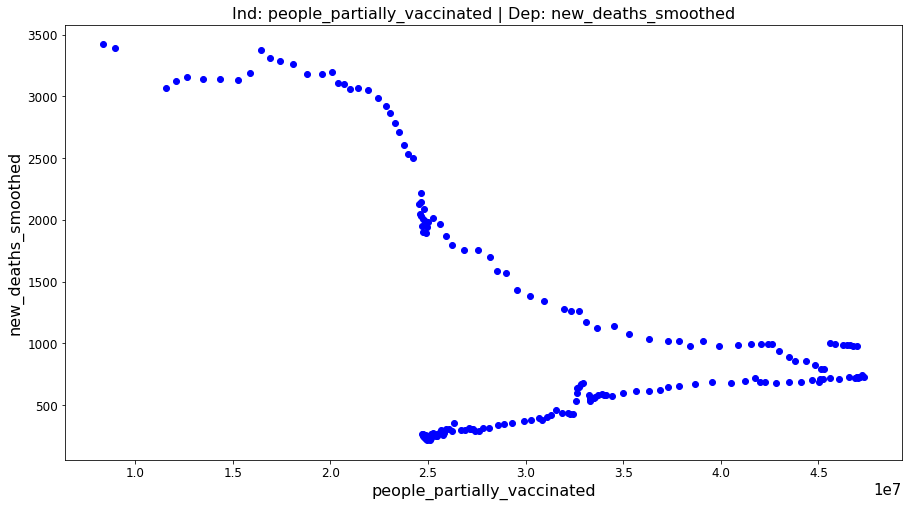

In [21]:
# Plotting scatter plots for RQ1
plot_scatter_plot(rq1_ind, rq1_dep, df_us)

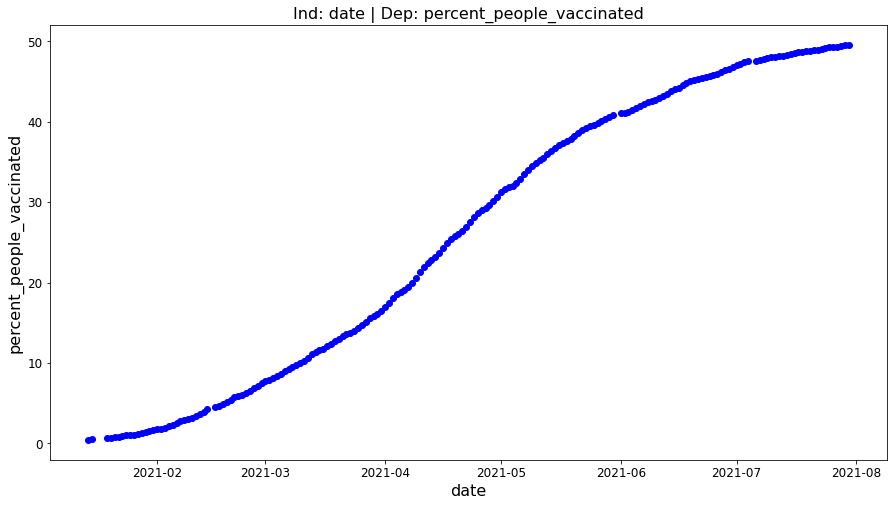

In [22]:
# Plotting scatter plots for RQ2
plot_scatter_plot(rq2_ind, rq2_dep, df_us)

## 4. Data Preparation (Data Cleaning)

### 4.1 Check Missing Values

In [23]:
# Define variables to be checked
check_vars = rq1_vars + rq2_dep

In [24]:
display_missing_indexes(df_us)



Total missing index count =  557
Assigned Index:  9199    Calculated Index:  0
Assigned Index:  9200    Calculated Index:  1
Assigned Index:  9201    Calculated Index:  2
Assigned Index:  9202    Calculated Index:  3
Assigned Index:  9203    Calculated Index:  4
Assigned Index:  9204    Calculated Index:  5
Assigned Index:  9205    Calculated Index:  6
Assigned Index:  9206    Calculated Index:  7
Assigned Index:  9207    Calculated Index:  8
Assigned Index:  9208    Calculated Index:  9
Assigned Index:  9209    Calculated Index:  10
Assigned Index:  9210    Calculated Index:  11
Assigned Index:  9211    Calculated Index:  12
Assigned Index:  9212    Calculated Index:  13
Assigned Index:  9213    Calculated Index:  14
Assigned Index:  9214    Calculated Index:  15
Assigned Index:  9215    Calculated Index:  16
Assigned Index:  9216    Calculated Index:  17
Assigned Index:  9217    Calculated Index:  18
Assigned Index:  9218    Calculated Index:  19
Assigned Index:  9219    Calculated

In [25]:
display_missing_val_dates(check_vars, df_us)

First index and date in the record:  9199   2020-01-22
Name: date, dtype: datetime64[ns] 

Last index and date in the record:  9755   2021-07-31
Name: date, dtype: datetime64[ns] 

Dates of Missing  people_fully_vaccinated  data:
2020-01-22 00:00:00
2020-01-23 00:00:00
2020-01-24 00:00:00
2020-01-25 00:00:00
2020-01-26 00:00:00
2020-01-27 00:00:00
2020-01-28 00:00:00
2020-01-29 00:00:00
2020-01-30 00:00:00
2020-01-31 00:00:00
2020-02-01 00:00:00
2020-02-02 00:00:00
2020-02-03 00:00:00
2020-02-04 00:00:00
2020-02-05 00:00:00
2020-02-06 00:00:00
2020-02-07 00:00:00
2020-02-08 00:00:00
2020-02-09 00:00:00
2020-02-10 00:00:00
2020-02-11 00:00:00
2020-02-12 00:00:00
2020-02-13 00:00:00
2020-02-14 00:00:00
2020-02-15 00:00:00
2020-02-16 00:00:00
2020-02-17 00:00:00
2020-02-18 00:00:00
2020-02-19 00:00:00
2020-02-20 00:00:00
2020-02-21 00:00:00
2020-02-22 00:00:00
2020-02-23 00:00:00
2020-02-24 00:00:00
2020-02-25 00:00:00
2020-02-26 00:00:00
2020-02-27 00:00:00
2020-02-28 00:00:00
2020-02-29

Total Missing Values:  6 


Dates of Missing  percent_people_vaccinated  data:
2020-01-22 00:00:00
2020-01-23 00:00:00
2020-01-24 00:00:00
2020-01-25 00:00:00
2020-01-26 00:00:00
2020-01-27 00:00:00
2020-01-28 00:00:00
2020-01-29 00:00:00
2020-01-30 00:00:00
2020-01-31 00:00:00
2020-02-01 00:00:00
2020-02-02 00:00:00
2020-02-03 00:00:00
2020-02-04 00:00:00
2020-02-05 00:00:00
2020-02-06 00:00:00
2020-02-07 00:00:00
2020-02-08 00:00:00
2020-02-09 00:00:00
2020-02-10 00:00:00
2020-02-11 00:00:00
2020-02-12 00:00:00
2020-02-13 00:00:00
2020-02-14 00:00:00
2020-02-15 00:00:00
2020-02-16 00:00:00
2020-02-17 00:00:00
2020-02-18 00:00:00
2020-02-19 00:00:00
2020-02-20 00:00:00
2020-02-21 00:00:00
2020-02-22 00:00:00
2020-02-23 00:00:00
2020-02-24 00:00:00
2020-02-25 00:00:00
2020-02-26 00:00:00
2020-02-27 00:00:00
2020-02-28 00:00:00
2020-02-29 00:00:00
2020-03-01 00:00:00
2020-03-02 00:00:00
2020-03-03 00:00:00
2020-03-04 00:00:00
2020-03-05 00:00:00
2020-03-06 00:00:00
2020-03-07 00:00:00
2

#### Comment on the result:
Both the variables "people_fully_vaccinated" and "people_partially_vaccinated" have quite a lot of missing values while "new_cases_smoothed" and "new_deaths_smoothed" only has 6 missing values. Therefore, we need to check the exact dates of the missing values to determine how we can handle these missing values.

In [26]:
group_missing_val_by_month(check_vars, df_us)

Group Missing values of people_fully_vaccinated by month
month
2020-01    10
2020-02    29
2020-03    31
2020-04    30
2020-05    31
2020-06    30
2020-07    31
2020-08    31
2020-09    30
2020-10    31
2020-11    30
2020-12    31
2021-01    16
2021-02     1
2021-03     0
2021-04     0
2021-05     1
2021-06     0
2021-07     2
dtype: int64


Group Missing values of people_partially_vaccinated by month
month
2020-01    10
2020-02    29
2020-03    31
2020-04    30
2020-05    31
2020-06    30
2020-07    31
2020-08    31
2020-09    30
2020-10    31
2020-11    30
2020-12    31
2021-01    16
2021-02     1
2021-03     0
2021-04     0
2021-05     1
2021-06     0
2021-07     2
dtype: int64


Group Missing values of new_cases_smoothed by month
month
2020-01    6
2020-02    0
2020-03    0
2020-04    0
2020-05    0
2020-06    0
2020-07    0
2020-08    0
2020-09    0
2020-10    0
2020-11    0
2020-12    0
2021-01    0
2021-02    0
2021-03    0
2021-04    0
2021-05    0
2021-06    0
2021-07    0
dty

#### Comment on the result:
The missing values of the variables "people_fully_vaccinated", "people_partially_vaccinated", and "percent_pop_vaccinated" are from January 2020 until January 2021, totalling up to 364 each. It indicates that the vaccination only start taking place in early of 2021. Therefore, the data before the date 2021-01-18 have to be discarded. Apart from this, there are three missing values after the date 2021-01-18. Since there is only three missing data after 2021-01-18, we will use listwise / case deletion to handle the missing data (directly deleting the data). Info: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3668100/


Both "new_cases_smoothed" and "new_deaths_smoothed" only has 6 missing values, which is the first six days of the record. The reason being is that the smoothed data is calculated by averaging the data of the past 7 days, including the day of reporting itself. These rows are already deleted due to the reason described in the paragraph before this.

#### Rows with these dates will be deleted:
- Every row before 2021-01-18
- 2021-02-15
- 2021-05-31
- 2021-06-18


### 4.2 Keep useful columns & data

In [27]:
# Drop all other columns except date and all_var
keep_var = rq1_vars + rq2_vars
df_us.drop(df_us.columns.difference(keep_var), 1, inplace=True)

In [28]:
# Drop unwanted rows
idx = df_us.index[df_us['date'] == pd.to_datetime("2021-01-18", format = '%Y-%m-%d')].tolist()

df_us.drop(df_us[
    (df_us.index <= idx[0]) |
    (df_us['date'] == pd.to_datetime("2021-02-15", format = '%Y-%m-%d')) |
    (df_us['date'] == pd.to_datetime("2021-05-31", format = '%Y-%m-%d')) |
    (df_us['date'] == pd.to_datetime("2021-06-18", format = '%Y-%m-%d')) |
    (df_us['date'] == pd.to_datetime("2021-07-05", format = '%Y-%m-%d')) |
    (df_us['date'] == pd.to_datetime("2021-07-31", format = '%Y-%m-%d')) ].index, inplace=True)

In [29]:
df_us.head()

,date,new_cases_smoothed,new_deaths_smoothed,people_fully_vaccinated,people_partially_vaccinated,percent_people_vaccinated
9562,2021-01-19,201207.143,3065.286,2023124.0,11572679.0,0.611211
9563,2021-01-20,194487.143,3125.143,2161419.0,12109022.0,0.652991
9564,2021-01-21,188500.000,3156.429,2394961.0,12658296.0,0.723547
9565,2021-01-22,181068.571,3143.857,2756953.0,13486140.0,0.832910
9566,2021-01-23,176625.857,3137.429,3027865.0,14362480.0,0.914756


In [30]:
df_us.tail()

,date,new_cases_smoothed,new_deaths_smoothed,people_fully_vaccinated,people_partially_vaccinated,percent_people_vaccinated
9750,2021-07-26,57301.143,271.571,163173366.0,25555916.0,49.296695
9751,2021-07-27,61306.429,296.714,163312474.0,25684001.0,49.338721
9752,2021-07-28,63697.714,304.429,163588042.0,25906138.0,49.421974
9753,2021-07-29,66996.714,305.286,163868916.0,26076991.0,49.506829
9754,2021-07-30,77826.857,357.571,164184080.0,26325103.0,49.602044


In [31]:
display_missing_indexes(df_us)



Total missing index count =  189
Assigned Index:  9562    Calculated Index:  0
Assigned Index:  9563    Calculated Index:  1
Assigned Index:  9564    Calculated Index:  2
Assigned Index:  9565    Calculated Index:  3
Assigned Index:  9566    Calculated Index:  4
Assigned Index:  9567    Calculated Index:  5
Assigned Index:  9568    Calculated Index:  6
Assigned Index:  9569    Calculated Index:  7
Assigned Index:  9570    Calculated Index:  8
Assigned Index:  9571    Calculated Index:  9
Assigned Index:  9572    Calculated Index:  10
Assigned Index:  9573    Calculated Index:  11
Assigned Index:  9574    Calculated Index:  12
Assigned Index:  9575    Calculated Index:  13
Assigned Index:  9576    Calculated Index:  14
Assigned Index:  9577    Calculated Index:  15
Assigned Index:  9578    Calculated Index:  16
Assigned Index:  9579    Calculated Index:  17
Assigned Index:  9580    Calculated Index:  18
Assigned Index:  9581    Calculated Index:  19
Assigned Index:  9582    Calculated

Assigned Index:  9741    Calculated Index:  175
Assigned Index:  9742    Calculated Index:  176
Assigned Index:  9743    Calculated Index:  177
Assigned Index:  9744    Calculated Index:  178
Assigned Index:  9745    Calculated Index:  179
Assigned Index:  9746    Calculated Index:  180
Assigned Index:  9747    Calculated Index:  181
Assigned Index:  9748    Calculated Index:  182
Assigned Index:  9749    Calculated Index:  183
Assigned Index:  9750    Calculated Index:  184
Assigned Index:  9751    Calculated Index:  185
Assigned Index:  9752    Calculated Index:  186
Assigned Index:  9753    Calculated Index:  187
Assigned Index:  9754    Calculated Index:  188


In [32]:
# Check the size of df_us
df_us.shape

(189, 6)

### 4.3 Check If there's any missing values

In [33]:
display_missing_val_dates(rq1_vars + rq2_dep, df_us)

First index and date in the record:  9562   2021-01-19
Name: date, dtype: datetime64[ns] 

Last index and date in the record:  9754   2021-07-30
Name: date, dtype: datetime64[ns] 

Dates of Missing  people_fully_vaccinated  data:
Total Missing Values:  0 


Dates of Missing  people_partially_vaccinated  data:
Total Missing Values:  0 


Dates of Missing  new_cases_smoothed  data:
Total Missing Values:  0 


Dates of Missing  new_deaths_smoothed  data:
Total Missing Values:  0 


Dates of Missing  percent_people_vaccinated  data:
Total Missing Values:  0 




## 5. Modelling

In [34]:
# Declare independent variables (RQ1)
x1 = np.array(df_us['people_fully_vaccinated'])
x2 = np.array(df_us['people_partially_vaccinated'])

# Declare dependent variables (RQ1)
y1 = np.array(df_us['new_cases_smoothed'])
y2 = np.array(df_us['new_deaths_smoothed'])

# Declare independent & dependent variables (RQ2)
x3 = np.array(df_us['date'])
y3 = np.array(df_us['percent_people_vaccinated'])

### 5.1 Model 1: people fully vaccinated vs new cases smoothed (RQ1)

Pipeline(steps=[('polynomial', PolynomialFeatures(degree=3)),
                ('modal', LinearRegression())])


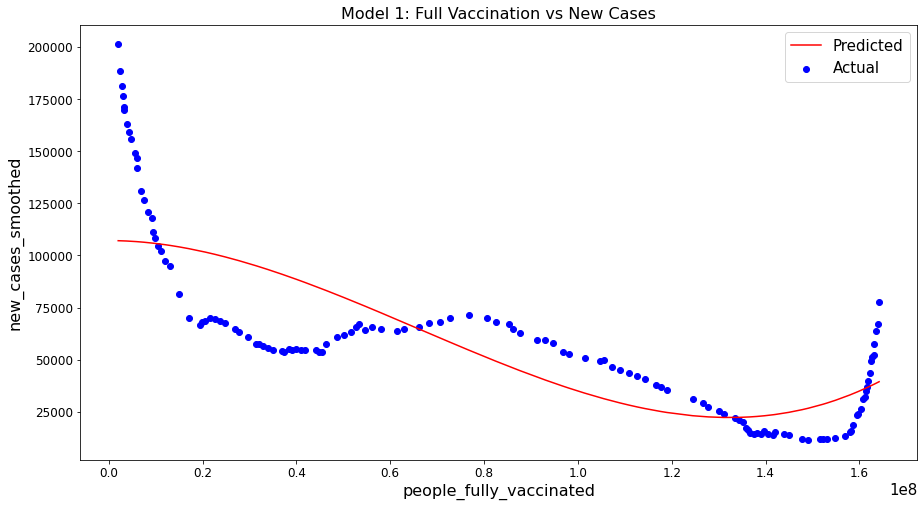

----- R2 Score Report -----
Model:  Model 1: Full Vaccination vs New Cases
Train Set:  0.5979483567910233
Test Set:  0.6257630144835009


In [35]:
m1 = Model(x1, y1, rq1_ind[0], rq1_dep[0], "Model 1: Full Vaccination vs New Cases")
m1.build_model()
m1.plot_model()
m1.compute_r2_score()

In [36]:
m1.test_model()

15313455379


### 5.2 Model 2: people fully vaccinated vs new deaths smoothed (RQ1)

Pipeline(steps=[('polynomial', PolynomialFeatures(degree=3)),
                ('modal', LinearRegression())])


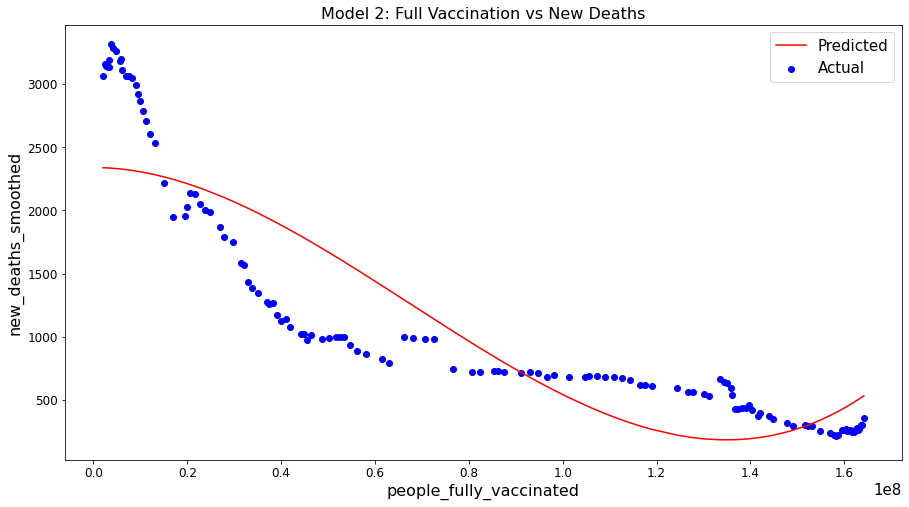

----- R2 Score Report -----
Model:  Model 2: Full Vaccination vs New Deaths
Train Set:  0.7691015755577807
Test Set:  0.8113601381337497


In [37]:
m2 = Model(x1, y2, rq1_ind[0], rq1_dep[1], "Model 2: Full Vaccination vs New Deaths")
m2.build_model()
m2.plot_model()
m2.compute_r2_score()

In [38]:
m2.test_model()

366421198


### 5.3 Model 3: people partially vaccinated vs new cases smoothed (RQ1)

Pipeline(steps=[('polynomial', PolynomialFeatures(degree=3)),
                ('modal', LinearRegression())])


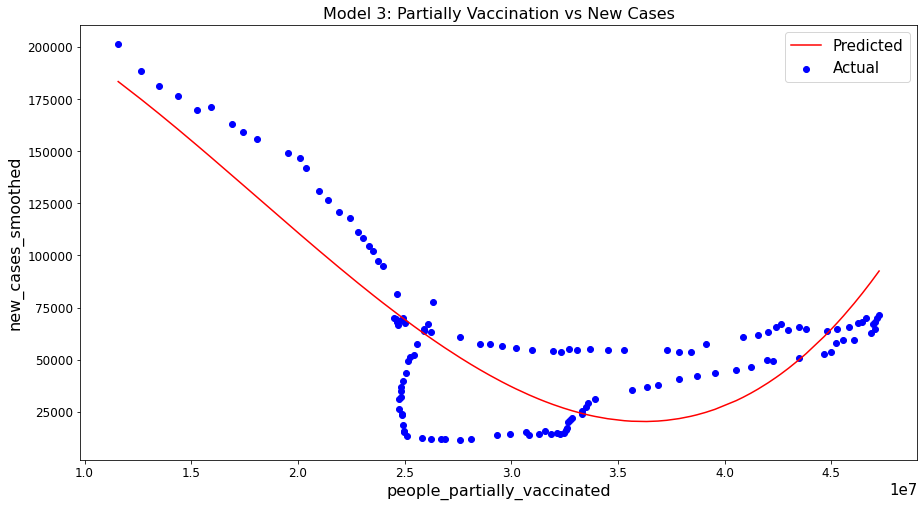

----- R2 Score Report -----
Model:  Model 3: Partially Vaccination vs New Cases
Train Set:  0.6732337222812936
Test Set:  0.4730308814761087


In [39]:
m3 = Model(x2, y1, rq1_ind[1], rq1_dep[0], "Model 3: Partially Vaccination vs New Cases")
m3.build_model()
m3.plot_model()
m3.compute_r2_score()

In [40]:
m3.test_model()

1940713510064


### 5.4 Model 4: people partially vaccinated vs new deaths smoothed (RQ1)

Pipeline(steps=[('polynomial', PolynomialFeatures(degree=3)),
                ('modal', LinearRegression())])


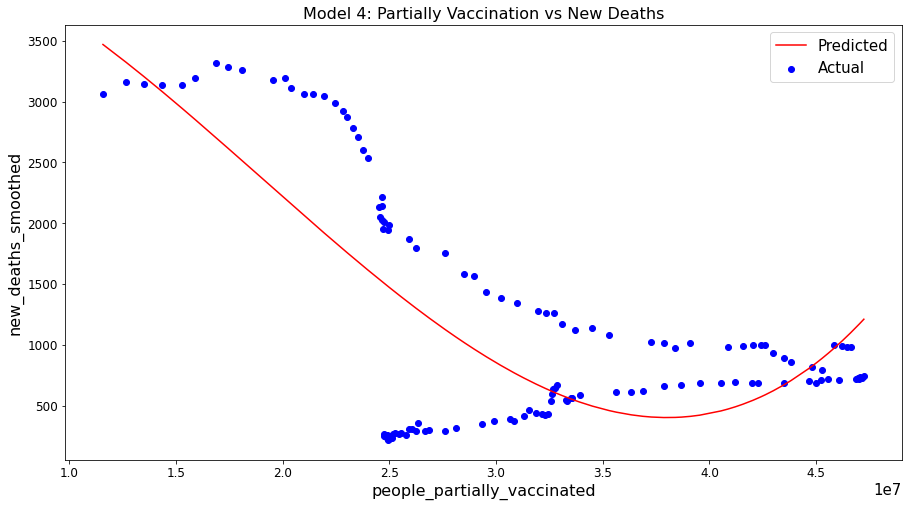

----- R2 Score Report -----
Model:  Model 4: Partially Vaccination vs New Deaths
Train Set:  0.4877570953136775
Test Set:  0.33320024254382175


In [41]:
m4 = Model(x2, y2, rq1_ind[1], rq1_dep[1], "Model 4: Partially Vaccination vs New Deaths")
m4.build_model()
m4.plot_model()
m4.compute_r2_score()

### 5.5 Model 5: Date vs Percentage of People Fully Vaccinated (RQ2)

Pipeline(steps=[('polynomial', PolynomialFeatures(degree=3)),
                ('modal', LinearRegression())])


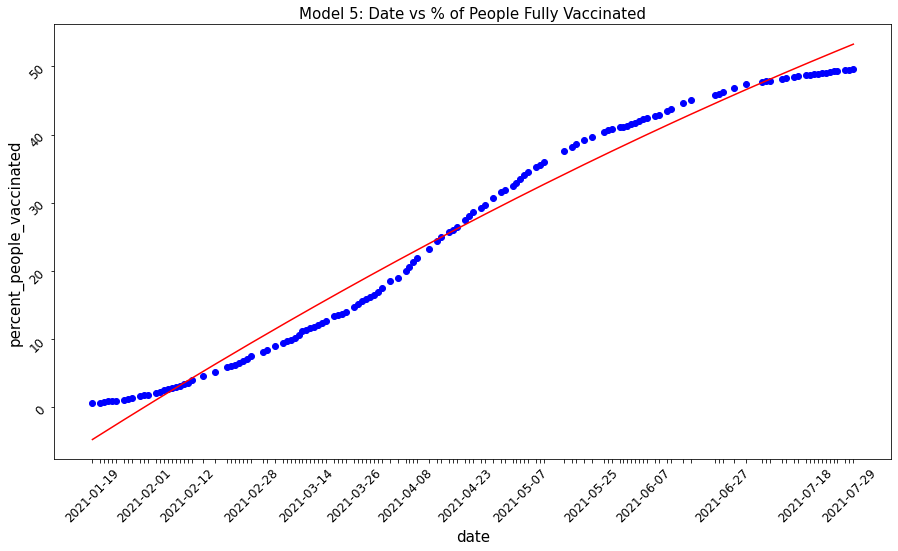

----- R2 Score Report -----
Model:  Model 5: Date vs % of People Fully Vaccinated
Train Set:  0.9798687435285242
Test Set:  0.9810183832296988


In [42]:
m5 = Model(x3, y3, rq2_ind[0], rq2_dep[0], "Model 5: Date vs % of People Fully Vaccinated")
m5.build_model()
m5.plot_model_with_date()
m5.compute_r2_score()